# Fixed wing drone swarm pursuit

## Imports

In [366]:
import pygame
from pygame.math import Vector2
from math import *
import numpy as np
import random as rd
from IPython.display import Image

## Constants

### Global constants

In [367]:
k_position = 1
k_velocity = 1
k_angle_penalty = 1
k_velocity_penalty = 1
k_theta = 1
k_omega = 1

width = 1280
height = 720

### Swarm constants

In [368]:
N_drones = 5
launch_position = np.zeros(2)
k_collision_angle = 1
k_collision_acceleration = 5

## Main classes

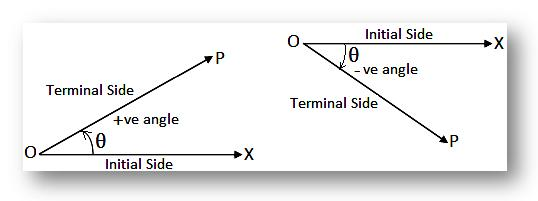

In [369]:
Image(filename='images/signed_angle.jpg') 

In [370]:
#returns the signed angle between two vectors u and v
def signed_angle(u, v):
    angle = atan2(v[1], v[0]) - atan2(u[1], u[0])
    angle = degrees(angle)
    if angle > 180:
        angle -= 360
    elif angle < -180:
        angle += 360
    return angle

def add_gaussian_noise(vec, mean=0, std_dev=1, size = 2):
    noise = np.random.normal(mean, std_dev, size)
    return vec + noise

In [371]:
'''
class Vehicle:
    def __init__(self, x, y, scaling=1, angle_0=0.0, length_0=4, max_steering_0=30, max_acceleration_0=5.0, k_steering_0=30, brake_deceleration_0=10, free_deceleration_0=2, max_velocity_0=20):
        self.position = Vector2(x, y)
        self.velocity = Vector2(0.0, 0.0)
        self.angle = angle_0
        self.length = length_0
        self.max_acceleration = max_acceleration_0
        self.max_steering = max_steering_0
        self.max_velocity = max_velocity_0/scaling
        self.brake_deceleration = brake_deceleration_0
        self.free_deceleration = free_deceleration_0
        self.k_steering = k_steering_0
        self.scaling = scaling

        self.acceleration = 0.0
        self.steering = 0.0

    def update(self, dt):
        # User input
        pressed = pygame.key.get_pressed()

        if pressed[pygame.K_UP]:
            if self.velocity.x < 0:
                self.acceleration = self.brake_deceleration
            else:
                self.acceleration += (1/self.scaling) * dt
        elif pressed[pygame.K_DOWN]:
            if self.velocity.x > 0:
                self.acceleration = -self.brake_deceleration
            else:
                self.acceleration -= (1/self.scaling) * dt
        elif pressed[pygame.K_SPACE]:
            if abs(self.velocity.x) > dt * self.brake_deceleration:
                self.acceleration = -copysign(self.brake_deceleration, self.velocity.x)
            else:
                self.acceleration = -self.velocity.x / dt
        else:
            if abs(self.velocity.x) > dt * self.free_deceleration:
                self.acceleration = -copysign(self.free_deceleration, self.velocity.x)
            else:
                if dt != 0:
                    self.acceleration = -self.velocity.x / dt
        self.acceleration = max(-self.max_acceleration, min(self.acceleration, self.max_acceleration))

        #steering
        if pressed[pygame.K_RIGHT]:
            self.steering -= self.k_steering*dt
        elif pressed[pygame.K_LEFT]:
            self.steering += self.k_steering*dt
        else:
            self.steering = 0
        self.steering = max(-self.max_steering, min(self.steering, self.max_steering))

        #velocity update
        self.velocity += (self.acceleration * dt, 0)
        self.velocity.x = max(-self.max_velocity, min(self.velocity.x, self.max_velocity))


        if self.steering:
            turning_radius = self.length / sin(radians(self.steering))
            angular_velocity = self.velocity.x / turning_radius
        else:
            angular_velocity = 0

        self.position += self.velocity.rotate(-self.angle) * dt
        self.angle += degrees(angular_velocity) * dt
    
    def draw(self, car_image, ppu, game):
        rotated_car = pygame.transform.rotate(car_image, self.angle)
        rect = rotated_car.get_rect()
        game.screen.blit(rotated_car, self.position * ppu - (rect.width / 2, rect.height / 2))
        return
'''

'\nclass Vehicle:\n    def __init__(self, x, y, scaling=1, angle_0=0.0, length_0=4, max_steering_0=30, max_acceleration_0=5.0, k_steering_0=30, brake_deceleration_0=10, free_deceleration_0=2, max_velocity_0=20):\n        self.position = Vector2(x, y)\n        self.velocity = Vector2(0.0, 0.0)\n        self.angle = angle_0\n        self.length = length_0\n        self.max_acceleration = max_acceleration_0\n        self.max_steering = max_steering_0\n        self.max_velocity = max_velocity_0/scaling\n        self.brake_deceleration = brake_deceleration_0\n        self.free_deceleration = free_deceleration_0\n        self.k_steering = k_steering_0\n        self.scaling = scaling\n\n        self.acceleration = 0.0\n        self.steering = 0.0\n\n    def update(self, dt):\n        # User input\n        pressed = pygame.key.get_pressed()\n\n        if pressed[pygame.K_UP]:\n            if self.velocity.x < 0:\n                self.acceleration = self.brake_deceleration\n            else:\n 

In [372]:
class Vehicle:
    def __init__(self, x=10, y=10, angle=0.0, length=4, max_steering=40, max_acceleration=2, min_acceleration=-2, scaling=1,
                 max_velocity_0=10, min_velocity_0=-10):
        self.position = Vector2(x, y)
        self.velocity = Vector2(0.0, 0.0)
        self.angle = angle
        self.length = length
        self.max_acceleration = max_acceleration
        self.min_acceleration = min_acceleration
        self.max_steering = max_steering
        self.max_velocity = max_velocity_0
        self.min_velocity = min_velocity_0
        self.brake_deceleration = 1
        self.free_deceleration = 0.2

        self.max_velocity = max_velocity_0/scaling
        self.min_velocity = min_velocity_0/scaling

        self.steering_acc = 0.0
        self.acceleration = 0.0
        self.steering = 0.0

    def update(self, dt):
        self.acceleration = rd.gauss(1,2)
        self.acceleration = max(self.min_acceleration, min(self.acceleration, self.max_acceleration))

        self.steering_acc = rd.gauss(0,70)
        self.velocity += (self.acceleration * dt, 0)
        self.velocity.x = max(self.min_velocity, min(self.velocity.x, self.max_velocity))
        self.steering += self.steering_acc*dt
        self.steering = max(-self.max_steering, min(self.steering, self.max_steering))
        if abs(self.steering) == self.max_steering:
            self.steering = 0
        if self.steering:
            turning_radius = self.length / sin(radians(self.steering))
            angular_velocity = self.velocity.x / turning_radius
        else:
            angular_velocity = 0

        self.position += self.velocity.rotate(-self.angle) * dt
        self.angle += degrees(angular_velocity) * dt

In [373]:
class Drone:
    def __init__(self, x, y, scaling=1, angle_0=0, length_0=1, max_steering_0=30, max_acceleration_0=5.0, k_steering_0=30,
                 brake_deceleration_0=10, free_deceleration_0=2, max_velocity_0=30, min_velocity_0=10,
                 target_position_0=Vector2(0,0), swarm_index_0=0, vision_radius_0=100):
        self.position = Vector2(x, y)
        self.velocity = Vector2(0.0, 0.0)
        self.angle = angle_0
        self.length = length_0
        self.max_acceleration = max_acceleration_0
        self.max_steering = max_steering_0
        self.max_velocity = max_velocity_0/scaling
        self.min_velocity = min_velocity_0/scaling
        self.brake_deceleration = brake_deceleration_0
        self.free_deceleration = free_deceleration_0
        self.k_steering = k_steering_0
        self.swarm_index = swarm_index_0
        self.vision_radius = vision_radius_0

        try:
            self.previous_theta = acos(Vector2.dot(target_position_0, Vector2(1.0, 0.0))/Vector2.magnitude(target_position_0)) - self.angle
        except:
            self.previous_theta = 0
        self.acceleration = 0.0
        self.steering = 0.0

    def angle_calculation(self, target_position):
        v = Vector2.normalize(target_position - self.position) # à bruiter parce qu'on connait pas la position exacte
        #v = add_gaussian_noise(v,mean=0,std_dev=0.5)
        v[1] = -v[1] # attention ca donne l'angle dans la base "écran" sinon
        u = Vector2(1.0, 0.0).rotate(self.angle) #obtenable avec un gyroscope
        
        theta = signed_angle(u, v)
        return theta

    def update(self, dt, target_position, target_velocity, drone_positions=[]):
        # Deltas
        del_position = Vector2.magnitude(target_position - self.position)
        del_velocity = Vector2.magnitude(target_velocity - self.velocity)

        theta = self.angle_calculation(target_position)

        #print(target_position.y, target_position.x)
        del_theta = (theta - self.previous_theta)

        self.previous_theta = theta

        collision_angle = 0
        collision_acceleration = 0

        # Avoiding collisions
        if (len(drone_positions) > 1):
            for i in range(len(drone_positions)):
                if (i != self.swarm_index):
                    # Angle
                    del_position = Vector2.magnitude(drone_positions[i] - self.position)

                    angle = self.angle_calculation(drone_positions[i])
                    #print(f"drone:{self.swarm_index},       angle:{round(angle, 2)},      del_pos:{round(del_position, 2)}")
                    
                    if (self.position != drone_positions[i]):
                        angle = self.angle_calculation(drone_positions[i])
                        if ((angle >= -180) & (angle <= 0)):
                            #if a drone is on the right, turn left
                            collision_angle += (1.0/del_position)*abs(sin(angle*pi/180.0))
                            #collision_angle += (1.0/del_position**2)
                        else:
                            #if a drone is on the left, turn right
                            collision_angle -= (1.0/del_position)*abs(sin(angle*pi/180.0))
                            #collision_angle -= (1.0/del_position**2)

                    # Acceleration
                    if ((angle >= -90) & (angle <= 90)):
                        #if a drone is in front, decelerate
                        collision_acceleration -= (1.0/del_position)*abs(cos(angle*pi/180.0))
                        #collision_acceleration -= (1.0/del_position**2)
                    else:
                        #if a drone is behind, accelerate
                        collision_acceleration += (1.0/del_position)*abs(cos(angle*pi/180.0))
                        #collision_acceleration += (1.0/del_position**2)
        if (self.swarm_index==0):
            print(self.position)
        #Gaz pedal controller
        self.acceleration = k_position*del_position + k_velocity*del_velocity + k_collision_acceleration*collision_acceleration
        self.acceleration = max(-self.max_acceleration, min(self.acceleration, self.max_acceleration))
        #self.acceleration = 0

        #steering controller
        #self.steering = k_theta*theta + k_omega*del_theta + k_collision_angle*collision_angle - k_velocity_penalty*Vector2.magnitude(self.velocity)/self.max_velocity
        self.steering = k_theta*theta + k_omega*del_theta + k_collision_angle*collision_angle
        self.steering = k_theta*theta
        self.steering = max(-self.max_steering, min(self.steering, self.max_steering))

        #velocity update
        self.velocity += Vector2(self.acceleration*dt, 0.0)
        self.velocity.x = max(self.min_velocity, min(self.velocity.x, self.max_velocity))

        if self.steering:
            turning_radius = self.length / sin(radians(self.steering))
            angular_velocity = self.velocity.x / turning_radius
        else:
            angular_velocity = 0

        self.position += self.velocity.rotate(-self.angle) * dt
        self.angle += degrees(angular_velocity) * dt

In [374]:
def draw(drone, car, car_image, drone_image, ppu, game, car_drawn=0):
    if (car_drawn==1):
        rotated_car = pygame.transform.rotate(car_image, car.angle)
        rect = rotated_car.get_rect()
        car_position = car.position * ppu
        car_position = [car_position[0]%width, car_position[1]%height]
        car_new_position =  [car_position[0] - rect.width/2, car_position[1] - rect.height/2]
        game.screen.blit(rotated_car, car_new_position)

    else:
        rotated_drone = pygame.transform.rotate(drone_image, drone.angle)
        rect = rotated_drone.get_rect()
        drone_position = drone.position * ppu
        drone_position = [drone_position[0]%width, drone_position[1]%height]
        drone_new_position =  [drone_position[0] - rect.width/2, drone_position[1] - rect.height/2]
        game.screen.blit(rotated_drone, drone_new_position)

        if (Vector2.magnitude(drone.position - car.position)*ppu > drone.vision_radius):
            color_0 = (255,0,0)
        else:
            color_0 = (0,255,0)
        pygame.draw.circle(center = drone_position, radius=drone.vision_radius, surface=game.screen, color=color_0, width=1)
    return

# Single drone pursuit

In [375]:
class Game:
    def __init__(self):
        pygame.init()
        pygame.display.set_caption("Drone pursuit")
        self.screen = pygame.display.set_mode((width, height))
        self.clock = pygame.time.Clock()
        self.ticks = 60
        self.exit = False

    def run(self):
        car_image_path = "car.png"
        drone_image_path = "drone.png"
        car_image = pygame.image.load(car_image_path)
        drone_image = pygame.image.load(drone_image_path)
        taille_car = car_image.get_size()
        scaling_car = 10
        taille_car = [taille_car[0]/scaling_car, taille_car[1]/scaling_car]
        car_image = pygame.transform.scale(car_image, taille_car)

        taille_drone = drone_image.get_size()
        scaling_drone = 10
        taille_drone = [taille_drone[0]/scaling_drone, taille_drone[1]/scaling_drone]

        car_image = pygame.transform.scale(car_image, taille_car)
        drone_image = pygame.transform.scale(drone_image, taille_drone)

        car = Vehicle(x=10, y=10, scaling=scaling_car)
        drone = Drone(x=5, y=20, scaling=scaling_drone)
        ppu = 32

        while not self.exit:
            dt = self.clock.get_time() / 1000

            # Event queue
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.exit = True

            # Logic
            car.update(dt)

            drone.update(dt, target_position=car.position, target_velocity=car.velocity)
            
            # Drawing
            self.screen.fill((0, 0, 0))
            draw(car, car_image, ppu, self)
            draw(drone, drone_image, ppu, self)
            
            pygame.display.flip()

            self.clock.tick(self.ticks)
        pygame.quit()

## Drone swarm pursuit

### Swarm class

In [376]:
class Swarm():
    def __init__(self, N_drones_0, launch_position_0, scaling_drone=1):
        self.swarm_list = []
        self.drone_positions = []
        self.N_drones = N_drones_0
        for i in range(self.N_drones):
            position = launch_position_0 + np.random.normal(loc=0, scale=10, size=2)
            x = position[0]
            y = position[1]
            self.swarm_list.append(Drone(x=x, y=y, scaling=scaling_drone, swarm_index_0=i))
            self.drone_positions.append(self.swarm_list[i].position)

    def update(self, dt, target_position, target_velocity):
        for i in range(self.N_drones):
            self.swarm_list[i].update(dt, target_position, target_velocity, self.drone_positions)
            self.drone_positions[i] = self.swarm_list[i].position

    def draw(self, car, car_image, drone_image, ppu, game):
        for i in range(self.N_drones):
            draw(drone=self.swarm_list[i], car=car, car_image=car_image, drone_image=drone_image, ppu=ppu, game=game, car_drawn=0)

### Swarm game

In [377]:
class Swarm_game:
    def __init__(self):
        pygame.init()
        pygame.display.set_caption("Drone pursuit")
        self.screen = pygame.display.set_mode((width, height))
        self.clock = pygame.time.Clock()
        self.ticks = 60
        self.exit = False

    def run(self):
        car_image_path = "car.png"
        drone_image_path = "drone.png"
        car_image = pygame.image.load(car_image_path)
        drone_image = pygame.image.load(drone_image_path)
        taille_car = car_image.get_size()
        scaling_car = 10
        taille_car = [taille_car[0]/scaling_car, taille_car[1]/scaling_car]
        car_image = pygame.transform.scale(car_image, taille_car)

        taille_drone = drone_image.get_size()
        scaling_drone = 10
        taille_drone = [taille_drone[0]/scaling_drone, taille_drone[1]/scaling_drone]

        car_image = pygame.transform.scale(car_image, taille_car)
        drone_image = pygame.transform.scale(drone_image, taille_drone)

        car = Vehicle(x=10, y=10, scaling=scaling_car)
        swarm = Swarm(N_drones_0=N_drones, scaling_drone=scaling_drone, launch_position_0=launch_position)
        ppu = 32

        while not self.exit:
            dt = self.clock.get_time() / 1000

            # Event queue
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.exit = True

            # Logic
            car.update(dt)

            swarm.update(dt, target_position=car.position, target_velocity=car.velocity)
            
            # Drawing
            self.screen.fill((0, 0, 0))
            draw(drone=0, car=car, car_image=car_image, drone_image=drone_image, ppu=ppu, game=self, car_drawn=1)
            swarm.draw(car=car, car_image=car_image, drone_image=drone_image, ppu=ppu, game=self)
            
            pygame.display.flip()

            self.clock.tick(self.ticks)
        pygame.quit()

## Run
You can either run the swarm simulation, or the single drone one

### Swarm simulation

In [378]:
game = Swarm_game()
game.run()

[-4.0872, 12.9129]
[-4.0872, 12.9129]
[-4.06876, 12.9129]
[-4.05012, 12.9128]
[-4.0302, 12.9127]
[-4.009, 12.9124]
[-3.98503, 12.9121]
[-3.96119, 12.9116]
[-3.93608, 12.911]
[-3.90796, 12.9102]
[-3.88021, 12.9092]
[-3.8512, 12.9081]
[-3.8209, 12.9068]
[-3.78728, 12.9052]
[-3.75437, 12.9034]
[-3.71797, 12.9013]
[-3.68244, 12.899]
[-3.62383, 12.8949]
[-3.58256, 12.8917]
[-3.54246, 12.8884]
[-3.5011, 12.8848]
[-3.45298, 12.8803]
[-3.40612, 12.8756]
[-3.35784, 12.8706]
[-3.31116, 12.8655]
[-3.26049, 12.8597]
[-3.20985, 12.8537]
[-3.15923, 12.8474]
[-3.10865, 12.8409]
[-3.05809, 12.8342]
[-3.00756, 12.8273]
[-2.95706, 12.8202]
[-2.90659, 12.8129]
[-2.85614, 12.8054]
[-2.80571, 12.7978]
[-2.75828, 12.7905]
[-2.71086, 12.783]
[-2.65754, 12.7744]
[-2.60721, 12.7662]
[-2.5569, 12.7579]
[-2.50661, 12.7494]
[-2.45634, 12.7408]
[-2.40608, 12.7321]
[-2.35585, 12.7233]
[-2.30563, 12.7144]
[-2.25544, 12.7054]
[-2.20525, 12.6963]
[-2.15804, 12.6876]
[-2.10788, 12.6784]
[-2.05774, 12.6691]
[-2.00762, 1

KeyboardInterrupt: 

### Single drone simulation

In [ ]:
game = Game()
game.run()

[5, 20]


TypeError: draw() missing 2 required positional arguments: 'ppu' and 'game'